### Usefull imports

In [1]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import os
import sklearn as sk
import mne
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Loading of the data

In [2]:
# Load data
# 8 channels = {'Fpz', 'T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8'}
# Trial time is 31.5 seconds
# sampling frequency is 120 
# Pre-processing done in Matlab:
# Downsampled
# High-pass filter of 2 Hz applied
# Low-pass filter of 30 Hz applied
data = loadmat('Data/xsub-01/xsub-01_gdf.mat')
X = data['X']    # EEG data: channels x samples x trials
V = data['V']    # Codes: bits x codes
y = data['y']    # Labels: 1 x trials

print(X.shape," X shape")
print(V.shape," V shape")
print(y.shape," y shape")
n_channels, n_samples, n_trials = X.shape

Xsingletrial = X[:,:,0]

ws = 36
E = np.zeros((Xsingletrial.shape[0],ws,Xsingletrial.shape[1]-ws))


for i in range(Xsingletrial.shape[1]-ws-1):
    for j in range(Xsingletrial.shape[0]):
        E[j,:,i] = Xsingletrial[j,i:i+ws]
    
print(E.shape)

Epochs = np.zeros((X.shape[0],ws,X.shape[2],X.shape[1]-ws))
for t in range(X.shape[2]-1):
    for i in range(X.shape[1]-ws-1):
        for j in range(X.shape[0]):
            Epochs[j,:,t,i] = X[j,i:i+ws,t]
    
# print(Epochs.shape)
# print(Epochs[:,:,1,:3])
data

(8, 3780, 100)  X shape
(252, 20)  V shape
(100, 1)  y shape
(8, 36, 3744)


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  8 15:17:23 2021',
 '__version__': '1.0',
 '__globals__': [],
 'V': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 1, ..., 0, 1, 1],
        [1, 1, 0, ..., 1, 0, 0],
        [1, 1, 0, ..., 1, 0, 0]], dtype=uint8),
 'X': array([[[  3.73821213,   2.38747554,  -3.14860954, ...,  -2.56397188,
            1.21772962,   1.08826672],
         [  5.26288929,   4.48987484,  -3.79930808, ...,  -3.73435598,
            2.75001552,   1.32468632],
         [  2.52141219,   6.39701104,  -0.4188233 , ...,  -3.91437847,
            3.83971828,   1.94074236],
         ...,
         [ -3.6996868 ,   3.89762172,  -2.10655717, ...,  -6.05456303,
           -3.25238405,   4.6674365 ],
         [  0.3434824 ,   2.7346114 ,  -1.42944733, ...,  -3.80460868,
           -4.66552178,   5.42047026],
         [  7.00368991,  -1.39276038,   0.01411778, ...,  -0.

### Printing of the shapes and basic plot 

(252, 20)
(100, 1)
(8, 3780, 100)


Text(0.5, 1.0, 'First trial of Fpz channel')

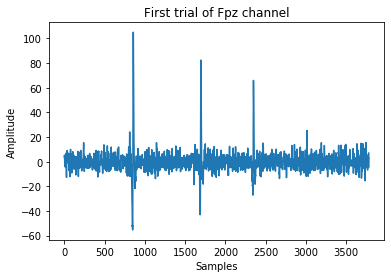

In [3]:
print(V.shape)
print(y.shape)
print(X.shape)
plt.plot(X[0,:,0])
plt.xlabel('Samples')

plt.ylabel('Amplitude')
plt.title('First trial of Fpz channel')
# Fun question about this plot:
# We see some very present peaks. Given that this electrode is placed at the front of the scalp (Fpz). What are these peaks?
# Answer: These are eyeblink artifacts. 

In [4]:
# def slice_data(X, window_size, nr_epochs,step_size):
#     print(X.shape)

#     sX = [X[:,i*step_size:i*step_size+window_size,:] for i in range(nr_epochs)]
#     sX = np.array(sX)
#     print(sX.shape)
#     sX = np.transpose(sX,(1,2,3,0))
#     print(sX.shape)
   
#     return sX

# samples = np.size(X,1)
# step_size = 2 # from 8ms per sample to 16 ms per sample fs/fr
# window_size = 24 # Number of samples from 120 hz sampling frequency and having 200 ms window
# nr_epochs = int(samples-(samples/step_size)-window_size)
# sX = slice_data(X,window_size,nr_epochs,step_size)
# sXtrain = sX[:,:,:80,:]
# sXtest = sX[:,:,80:,:]
# print(sXtrain.shape)
# print(sXtest.shape)

***Repeating of the codes***

In [4]:
print('Shape of code book before repeating of codes',V.shape)
V_ext = np.tile(V,(15,1))
print('Shape of code book after repeating of codes',V_ext.shape)
# trials x bits x codes

Shape of code book before repeating of codes (252, 20)
Shape of code book after repeating of codes (3780, 20)


***Slicing data to epochs***

In [5]:
def slice_data(X, V, window_size, nr_epochs,step_size):
    print('Original data size:',X.shape)

    sX = [X[:,i*2:i*2+window_size,:] for i in range(nr_epochs)]
    sV = [V[i*2,:] for i in range(nr_epochs)]
    
    sV = np.array(sV)
    sX = np.array(sX)
    print('Sliced code books shape before transposing:',sV.shape)
    
    print('Sliced data shape before transposing:',sX.shape)
    sX = np.transpose(sX,(1,2,3,0))
    print('Sliced data shape after transposing:',sX.shape)
   
    return sX, sV

In [6]:
step_size = 2 # from 8ms per sample to 16 ms per sample fs/fr
window_size = 36 # Number of samples from 120 hz sampling frequency and having 200 ms window
nr_epochs = int(n_samples-(n_samples/step_size)-window_size)
sX, sV = slice_data(X,V_ext,window_size,nr_epochs,step_size)



validation = np.zeros((y.shape[0],sV.shape[0]))
for i in range(y.shape[0]):
    letter_index = y[i,0]-1
    validation[i] = sV[:,letter_index]
    

Original data size: (8, 3780, 100)
Sliced code books shape before transposing: (1854, 20)
Sliced data shape before transposing: (1854, 8, 36, 100)
Sliced data shape after transposing: (8, 36, 100, 1854)


***Splitting data into train and test***

In [8]:
train_size = int((4/5)*n_trials)
sXtrain = sX[:,:,:train_size,:]
sXtest = sX[:,:,train_size:,:]
print('Shape of the training set:',sXtrain.shape)
print('Shape of the testing set:',sXtest.shape)


validation_train = validation[:train_size,:]
validation_test = validation[train_size:,:]

print('Shape of the training validation set:',validation_train.shape)
print('Shape of the testing validation set:',validation_test.shape)

Shape of the training set: (8, 36, 80, 1854)
Shape of the testing set: (8, 36, 20, 1854)
Shape of the training validation set: (80, 1854)
Shape of the testing validation set: (20, 1854)


***Reshaping train and test***

In [9]:
c_train, w_train, t_train, e_train = sXtrain.shape

Xtrain = sXtrain.reshape(c_train*w_train, t_train*e_train)
Xtrain = Xtrain.transpose(1,0)
print(Xtrain.shape)
print(Xtrain)

ytrain = validation_train.reshape(t_train*e_train)
print(ytrain.shape)

(148320, 288)
[[ 3.73821213  5.26288929  2.52141219 ...  6.28305378  7.90490801
   7.6997078 ]
 [ 2.52141219  1.00609646 -1.81954001 ...  7.6997078   6.3323194
   3.68379796]
 [-1.81954001 -2.9135989  -1.47696881 ...  3.68379796  1.86662932
   2.77058202]
 ...
 [ 3.32887434  2.47287483  2.14888051 ... -1.97379471 -5.60011405
  -3.23794148]
 [ 2.14888051  3.14734331  3.78703128 ... -3.23794148  1.87132601
   3.50752163]
 [ 3.78703128  1.98655622 -1.44393239 ...  3.50752163  2.52260778
   2.19568672]]
(148320,)


In [10]:
c_test, w_test, t_test, e_test = sXtest.shape
Xtest = sXtest.reshape(c_test*w_test, t_test*e_test)
Xtest = Xtest.transpose(1,0)
print(Xtest.shape)

ytest = validation_test.reshape(t_test*e_test)
print(ytest.shape)

(37080, 288)
(37080,)


In [11]:
clf = LDA()
clf.fit(Xtrain, ytrain)
score = clf.score(Xtest, ytest) * 100
print('Accuracy validation: {:.2f}%'.format(score))

#clf.predict(Xtest)
pred = clf.predict(Xtest)

C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy validation: 68.96%


In [12]:
print(len(pred))
print(pred.shape)
pred[0]
counter = 0
for i in range(ytest.shape[0]):
    if pred[i] == ytest[i]:
        counter+=1
acc = (counter/len(pred))*100

print(acc)

37080
(37080,)
68.96170442286947


In [13]:
ytest_re = pred.reshape(t_test,e_test)    
print(ytest_re.shape)

pred0 = ytest_re[0,0:252]
print(len(pred0))
trial_num = y[80,0]
print(trial_num)

vec = np.zeros(20)
print(vec.shape)
for j in range(0,20):
    test0 = V[:,j]
    counter0 = 0
    for i in range(252):
        if pred0[i] == test0[i]:
            counter0+=1
    vec[j] = (counter0/len(pred0))*100
print(vec)
print(max(vec))
print(np.argmax(vec))

(20, 1854)
252
1
(20,)
[47.22222222 47.22222222 52.77777778 50.3968254  47.22222222 44.84126984
 51.19047619 50.3968254  48.01587302 44.84126984 51.98412698 54.36507937
 51.19047619 46.42857143 50.3968254  51.19047619 44.04761905 48.80952381
 51.19047619 50.3968254 ]
54.36507936507936
11


In [14]:
y[80,:]

array([1], dtype=uint8)

In [22]:
pred_proba = clf.predict_proba(Xtest)
print(pred_proba.shape)
print(ytest.shape)

predictions = np.zeros(ytest.size)
for i in range(2):
    print(pred_proba[:,i].shape)
    rho = np.corrcoef(pred_proba[:,i], ytest)
    predictions[i]=np.argmax(rho)

print(predictions)
print(predictions.sum())
pp = 100*np.mean(predictions == ytest)
pp

(37080, 2)
(37080,)
(37080,)
(37080,)
[0. 0. 0. ... 0. 0. 0.]
0.0


50.0